# Libraries and setup

In [1]:
import pandas as pd
import numpy as np
import os
import cv2
import gc
from PIL import Image
import matplotlib.pyplot as plt
from tqdm import tqdm
from tqdm.notebook import tqdm
from datetime import datetime
import json,itertools
from typing import Optional
from glob import glob
import warnings
warnings.filterwarnings("ignore")
import matplotlib.gridspec as gridspec
import matplotlib.patches as mpatches
import matplotlib as mpl
from sklearn.model_selection import StratifiedKFold, KFold, StratifiedGroupKFold
import random

from tensorflow import keras
import tensorflow as tf

import keras
from keras import backend as K
from keras.models import Model
from keras.losses import binary_crossentropy
from keras.callbacks import Callback, ModelCheckpoint, EarlyStopping
from keras.models import load_model, save_model
from matplotlib.patches import Rectangle

**Reproducibility**

In [2]:
# Set random seeds
def set_seed(seed=0):
    np.random.seed(seed)
    random.seed(seed)
    tf.random.set_seed(seed)
set_seed(seed=42)

In [3]:
# print(f"\n... ACCELERATOR SETUP STARTING ...\n")

# try:
#     TPU = tf.distribute.cluster_resolver.TPUClusterResolver()  
# except ValueError:
#     TPU = None

# if TPU:
#     print(f"\n... RUNNING ON TPU - {TPU.master()}...")
#     tf.config.experimental_connect_to_cluster(TPU)
#     tf.tpu.experimental.initialize_tpu_system(TPU)
#     strategy = tf.distribute.experimental.TPUStrategy(TPU)
# else:
#     print(f"\n... RUNNING ON CPU/GPU ...")
#     strategy = tf.distribute.get_strategy() 

# N_REPLICAS = strategy.num_replicas_in_sync
# print(f"... # OF REPLICAS: {N_REPLICAS} ...\n")
# print(f"\n... ACCELERATOR SETUP COMPLTED ...\n")

**Config**

In [4]:
BATCH_SIZE = 30
EPOCHS = 20
n_splits = 5
fold_selected = 2   
IMAGE_WIDTH = 256
IMAGE_HEIGHT = 256

# Data

To import dataset in kaggle click on + Add data in top right corner -> go to competitions and choose the uw-madison-gi-tract-image-segmentation datset

In [5]:
#from kaggle_datasets import KaggleDatasets
print("\n... DATA ACCESS SETUP STARTED ...\n")

DATA_DIR = "/kaggle/input/uw-madison-gi-tract-image-segmentation"
save_locally = None
load_locally = None

# if TPU:
#     # Google Cloud Dataset path to training and validation images
#     DATA_DIR = KaggleDatasets().get_gcs_path('uw-madison-gi-tract-image-segmentation')
#     save_locally = tf.saved_model.SaveOptions(experimental_io_device='/job:localhost')
#     load_locally = tf.saved_model.LoadOptions(experimental_io_device='/job:localhost')
# else:
#     DATA_DIR = "/kaggle/input/uw-madison-gi-tract-image-segmentation"
#     save_locally = None
#     load_locally = None


... DATA ACCESS SETUP STARTED ...



**Train set**

In [6]:
TRAIN_DIR = os.path.join(DATA_DIR, "train")
TRAIN_CSV = os.path.join(DATA_DIR, "train.csv")
train_df = pd.read_csv(TRAIN_CSV)
print(train_df.shape)
train_df.head()

(115488, 3)


,id,class,segmentation
0,case123_day20_slice_0001,large_bowel,NaN
1,case123_day20_slice_0001,small_bowel,NaN
2,case123_day20_slice_0001,stomach,NaN
3,case123_day20_slice_0002,large_bowel,NaN
4,case123_day20_slice_0002,small_bowel,NaN


**Test set**

In [7]:
TEST_CSV = os.path.join(DATA_DIR, 'sample_submission.csv')
test_df = pd.read_csv(TEST_CSV)

if len(test_df)==0:
    DEBUG=True
    test_df = train_df[115488-300:]
    #test_df["segmentation"]=''
    #test_df=test_df.rename(columns={"segmentation":"prediction"})
else:
    DEBUG=False

submission=test_df.copy()
submission["segmentation"]=''
submission=submission.rename(columns={"segmentation":"prediction"})
print(test_df.head())
print(submission.head())

                            id        class segmentation
115188  case30_day0_slice_0045  large_bowel          NaN
115189  case30_day0_slice_0045  small_bowel          NaN
115190  case30_day0_slice_0045      stomach          NaN
115191  case30_day0_slice_0046  large_bowel          NaN
115192  case30_day0_slice_0046  small_bowel          NaN
                            id        class prediction
115188  case30_day0_slice_0045  large_bowel           
115189  case30_day0_slice_0045  small_bowel           
115190  case30_day0_slice_0045      stomach           
115191  case30_day0_slice_0046  large_bowel           
115192  case30_day0_slice_0046  small_bowel           


# Preprocessing

In [8]:
def preprocessing(df, subset="train"):
    df["case"] = df["id"].apply(lambda x: int(x.split("_")[0].replace("case", "")))
    df["day"] = df["id"].apply(lambda x: int(x.split("_")[1].replace("day", "")))
    df["slice"] = df["id"].apply(lambda x: x.split("_")[3])
    if (subset=="train") or (DEBUG):
        DIR="../input/uw-madison-gi-tract-image-segmentation/train"
    else:
        DIR="../input/uw-madison-gi-tract-image-segmentation/test"
    
    all_images = glob(os.path.join(DIR, "**", "*.png"), recursive=True)
    x = all_images[0].rsplit("/", 4)[0] 

    path_partial_list = []
    for i in range(0, df.shape[0]):
        path_partial_list.append(os.path.join(x,
                              "case"+str(df["case"].values[i]),
                              "case"+str(df["case"].values[i])+"_"+ "day"+str(df["day"].values[i]),
                              "scans",
                              "slice_"+str(df["slice"].values[i])))
    df["path_partial"] = path_partial_list
    path_partial_list = []
    for i in range(0, len(all_images)):
        path_partial_list.append(str(all_images[i].rsplit("_",4)[0]))

    tmp_df = pd.DataFrame()
    tmp_df['path_partial'] = path_partial_list
    tmp_df['path'] = all_images

    df = df.merge(tmp_df, on="path_partial").drop(columns=["path_partial"])
    df["width"] = df["path"].apply(lambda x: int(x[:-4].rsplit("_",4)[1]))
    df["height"] = df["path"].apply(lambda x: int(x[:-4].rsplit("_",4)[2]))
    del x, path_partial_list, tmp_df
    
    return df

In [9]:
def restructure(df, subset="train"):
    # RESTRUCTURE  DATAFRAME
    df_out = pd.DataFrame({'id': df['id'][::3]})

    if True:
        df_out['large_bowel'] = df['segmentation'][::3].values
        df_out['small_bowel'] = df['segmentation'][1::3].values
        df_out['stomach'] = df['segmentation'][2::3].values

    df_out['path'] = df['path'][::3].values
    df_out['case'] = df['case'][::3].values
    df_out['day'] = df['day'][::3].values
    df_out['slice'] = df['slice'][::3].values
    df_out['width'] = df['width'][::3].values
    df_out['height'] = df['height'][::3].values

    df_out=df_out.reset_index(drop=True)
    df_out=df_out.fillna('')
    if subset=="train":
        df_out['count'] = np.sum(df_out.iloc[:,1:4]!='',axis=1).values
    
    return df_out

In [10]:
print(train_df.shape)
train_df = train_df[:115488-300]
train_df = preprocessing(train_df, subset="train")
print(train_df.shape)
print(train_df.head())

(115488, 3)
(115188, 9)
                         id        class segmentation  case  day slice  \
0  case123_day20_slice_0001  large_bowel          NaN   123   20  0001   
1  case123_day20_slice_0001  small_bowel          NaN   123   20  0001   
2  case123_day20_slice_0001      stomach          NaN   123   20  0001   
3  case123_day20_slice_0002  large_bowel          NaN   123   20  0002   
4  case123_day20_slice_0002  small_bowel          NaN   123   20  0002   

                                                path  width  height  
0  ../input/uw-madison-gi-tract-image-segmentatio...    266     266  
1  ../input/uw-madison-gi-tract-image-segmentatio...    266     266  
2  ../input/uw-madison-gi-tract-image-segmentatio...    266     266  
3  ../input/uw-madison-gi-tract-image-segmentatio...    266     266  
4  ../input/uw-madison-gi-tract-image-segmentatio...    266     266  


In [11]:
test_df=preprocessing(test_df, subset="test")
print(test_df.shape)
test_df.head()

(300, 9)


,id,class,segmentation,case,day,slice,path,width,height
0,case30_day0_slice_0045,large_bowel,NaN,30,0,0045,../input/uw-madison-gi-tract-image-segmentatio...,266,266
1,case30_day0_slice_0045,small_bowel,NaN,30,0,0045,../input/uw-madison-gi-tract-image-segmentatio...,266,266
2,case30_day0_slice_0045,stomach,NaN,30,0,0045,../input/uw-madison-gi-tract-image-segmentatio...,266,266
3,case30_day0_slice_0046,large_bowel,NaN,30,0,0046,../input/uw-madison-gi-tract-image-segmentatio...,266,266
4,case30_day0_slice_0046,small_bowel,NaN,30,0,0046,../input/uw-madison-gi-tract-image-segmentatio...,266,266


In [12]:
train_df=restructure(train_df, subset="train")
train_df.head()

,id,large_bowel,small_bowel,stomach,path,case,day,slice,width,height,count
0,case123_day20_slice_0001,,,,../input/uw-madison-gi-tract-image-segmentatio...,123,20,0001,266,266,0
1,case123_day20_slice_0002,,,,../input/uw-madison-gi-tract-image-segmentatio...,123,20,0002,266,266,0
2,case123_day20_slice_0003,,,,../input/uw-madison-gi-tract-image-segmentatio...,123,20,0003,266,266,0
3,case123_day20_slice_0004,,,,../input/uw-madison-gi-tract-image-segmentatio...,123,20,0004,266,266,0
4,case123_day20_slice_0005,,,,../input/uw-madison-gi-tract-image-segmentatio...,123,20,0005,266,266,0


In [13]:
test_df=restructure(test_df, subset="test")
test_df.head()

,id,large_bowel,small_bowel,stomach,path,case,day,slice,width,height
0,case30_day0_slice_0045,,,,../input/uw-madison-gi-tract-image-segmentatio...,30,0,0045,266,266
1,case30_day0_slice_0046,,,,../input/uw-madison-gi-tract-image-segmentatio...,30,0,0046,266,266
2,case30_day0_slice_0047,,,,../input/uw-madison-gi-tract-image-segmentatio...,30,0,0047,266,266
3,case30_day0_slice_0048,,,,../input/uw-madison-gi-tract-image-segmentatio...,30,0,0048,266,266
4,case30_day0_slice_0049,,,,../input/uw-madison-gi-tract-image-segmentatio...,30,0,0049,266,266


In [14]:
# Remove mislabeled training data
print(train_df.shape, test_df.shape)
train_df = train_df[(train_df['case']!=7)|(train_df['day']!=0)].reset_index(drop=True)
train_df = train_df[(train_df['case']!=81)|(train_df['day']!=30)].reset_index(drop=True)
print(train_df.shape, test_df.shape)

(38396, 11) (100, 10)
(38108, 11) (100, 10)


In [15]:
# Garbage collection
gc.collect()

92

In [16]:
print(train_df.shape, test_df.shape)

(38108, 11) (100, 10)


# Helper functions

In [17]:
def rle_decode(mask_rle, shape, color=1):
    '''
    mask_rle: run-length as string formated (start length)
    shape: (height,width) of array to return 
    Returns numpy array, 1 - mask, 0 - background
    '''
    s = np.array(mask_rle.split(), dtype=int)   
    starts = s[0::2] - 1 # Every even value is the start, every odd value is the "run" length
    lengths = s[1::2]
    ends = starts + lengths
    if len(shape)==3:
        h, w, d = shape
        img = np.zeros((h * w, d), dtype=np.float32)
    else:
        h, w = shape
        img = np.zeros((h * w,), dtype=np.float32)
    for lo, hi in zip(starts, ends):
        img[lo : hi] = color    
    return img.reshape(shape)    

In [18]:
#run length encoding
def rle_encode(img):
    '''
    img: numpy array, 1 - mask, 0 - background
    Returns run length as string formated
    '''
    pixels = img.flatten()
    pixels = np.concatenate([[0], pixels, [0]])
    runs = np.where(pixels[1:] != pixels[:-1])[0] + 1
    runs[1::2] -= runs[::2]
    return ' '.join(str(x) for x in runs)

In [19]:
# Metrics
def dice_coef(y_true, y_pred, smooth=1):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)

def iou_coef(y_true, y_pred, smooth=1):
    intersection = K.sum(K.abs(y_true * y_pred), axis=[1,2,3])
    union = K.sum(y_true,[1,2,3])+K.sum(y_pred,[1,2,3])-intersection
    iou = K.mean((intersection + smooth) / (union + smooth), axis=0)
    return iou

def dice_loss(y_true, y_pred):
    smooth = 1.
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = y_true_f * y_pred_f
    score = (2. * K.sum(intersection) + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)
    return 1. - score

def bce_dice_loss(y_true, y_pred):
    return binary_crossentropy(tf.cast(y_true, tf.float32), y_pred) + dice_loss(tf.cast(y_true, tf.float32), y_pred)

In [20]:
class DataGenerator(tf.keras.utils.Sequence):
    def __init__(self, df, batch_size = BATCH_SIZE, subset="train", shuffle=False, width=IMAGE_WIDTH, height=IMAGE_HEIGHT):
        super().__init__()
        self.df = df
        self.shuffle = shuffle
        self.subset = subset
        self.batch_size = batch_size
        self.indexes = np.arange(len(df))
        self.width=width
        self.height=height
        self.on_epoch_end()

    def __len__(self):
        return int(np.floor(len(self.df) / self.batch_size))
    
    def on_epoch_end(self):
        if self.shuffle == True:
            np.random.shuffle(self.indexes)
    
    def __getitem__(self, index):
        X = np.empty((self.batch_size,self.width,self.height,3))
        y = np.empty((self.batch_size,self.width,self.height,3))
        indexes = self.indexes[index*self.batch_size:(index+1)*self.batch_size]
        for i, img_path in enumerate(self.df['path'].iloc[indexes]):
            w=self.df['width'].iloc[indexes[i]]
            h=self.df['height'].iloc[indexes[i]]
            img = self.__load_grayscale(img_path)
            X[i,] =img  
            if self.subset == 'train':
                for k,j in enumerate(["large_bowel","small_bowel","stomach"]):
                    rles = self.df[j].iloc[indexes[i]]
                    mask = rle_decode(rles, shape=(h, w, 1))
                    mask = cv2.resize(mask, (self.width, self.height))
                    y[i,:,:,k] = mask
        if self.subset == 'train':
            return X,y
        else: 
            return X
        
    def __load_grayscale(self, img_path):
        img = cv2.imread(img_path, cv2.IMREAD_ANYDEPTH)
        dsize = (self.width, self.height)
        img = cv2.resize(img, dsize)
        img = img.astype(np.float32) / 255.
        img = np.expand_dims(img, axis=-1)
        return img

In [21]:
def load_grayscale(img_path):
    img = cv2.imread(img_path, cv2.IMREAD_ANYDEPTH)
    print(img.shape)
    print(img.max())
    dsize = (img.shape[0]-img.shape[0]%32, img.shape[1]-img.shape[1]%32)
    img = cv2.resize(img, dsize)
    img = img.astype(np.float32)
    print(img.max())
    img = img / 255.
    img = np.tile(np.expand_dims(img, axis=-1),3)
    print(img.shape)
    print(img.max())
    return img

img = load_grayscale(train_df['path'].iloc[14])

(266, 266)
8341
8292.0
(256, 256, 3)
32.517647


# EDA

In [22]:
def open_gray16(_path, normalize=True, to_rgb=False):
    if normalize:
        if to_rgb:
            return np.tile(np.expand_dims(cv2.imread(_path, cv2.IMREAD_ANYDEPTH)/255., axis=-1), 3)
        else:
            return cv2.imread(_path, cv2.IMREAD_ANYDEPTH)/255.
    else:
        if to_rgb:
            return np.tile(np.expand_dims(cv2.imread(_path, cv2.IMREAD_ANYDEPTH), axis=-1), 3)
        else:
            return cv2.imread(_path, cv2.IMREAD_ANYDEPTH)

In [23]:
def examine_id(DEMO_ID, seg_masks=False):
  demo_ex = train_df[train_df.id==DEMO_ID].squeeze()
  display(demo_ex.to_frame())

  print(f"\n\n...IMAGE ...\n")
  plt.figure(figsize=(6,6))
  plt.imshow(open_gray16(demo_ex.path), cmap="gray")
  plt.title(f"Original Grayscale Image For ID: {demo_ex.id}", fontweight="bold")
  plt.axis(False)
  plt.show()

  if(seg_masks):
    print(f"\n\n... 3 SEGMENTATION MASKS ...\n")

    plt.figure(figsize=(14,7))
    for i, _seg_type in enumerate(["large_bowel", "small_bowel", "stomach"]):
        if pd.isna(demo_ex[f"{_seg_type}"]): continue
        plt.subplot(1,3,i+1)
        s = demo_ex[f"{_seg_type}"]
        plt.imshow(rle_decode(demo_ex[f"{_seg_type}"], shape=(demo_ex.height, demo_ex.width), color=1))
        plt.title(f"RLE Encoding For {_seg_type} Segmentation", fontweight="bold")
        plt.axis(False)
    plt.tight_layout()
    plt.show()

  print(f"\n\n...IMAGE WITH AN RGB SEGMENTATION MASK OVERLAY ...\n")

  _img = open_gray16(demo_ex.path, to_rgb=True)
  _img = ((_img-_img.min())/(_img.max()-_img.min())).astype(np.float32)
  _seg_rgb = np.stack([rle_decode(demo_ex[f"{_seg_type}"], shape=(demo_ex.height, demo_ex.width), color=1) if not pd.isna(demo_ex[f"{_seg_type}"]) else np.zeros((demo_ex.height, demo_ex.width)) for _seg_type in ["large_bowel", "small_bowel", "stomach"]], axis=-1).astype(np.float32)
  seg_overlay = cv2.addWeighted(src1=_img, alpha=0.99, src2=_seg_rgb, beta=0.33, gamma=0.0)

  plt.figure(figsize=(6,6))
  plt.imshow(seg_overlay)
  plt.title(f"Segmentation Overlay For ID: {demo_ex.id}", fontweight="bold")
  handles = [Rectangle((0,0),1,1, color=_c) for _c in [(0.667,0.0,0.0), (0.0,0.667,0.0), (0.0,0.0,0.667)]]
  labels = ["Large Bowel Segmentation Map", "Small Bowel Segmentation Map", "Stomach Segmentation Map"]
  plt.legend(handles,labels)
  plt.axis(False)
  plt.show()



... SINGLE ID EXPLORATION ...




,81
id,case123_day20_slice_0082
large_bowel,17481 4 17746 7 18010 10 18275 12 18539 14 188...
small_bowel,22236 2 22500 6 22765 8 23030 10 23296 10 2356...
stomach,11052 8 11314 15 11578 19 11843 23 12108 26 12...
path,../input/uw-madison-gi-tract-image-segmentatio...
case,123
day,20
slice,0082
width,266
height,266




...IMAGE ...



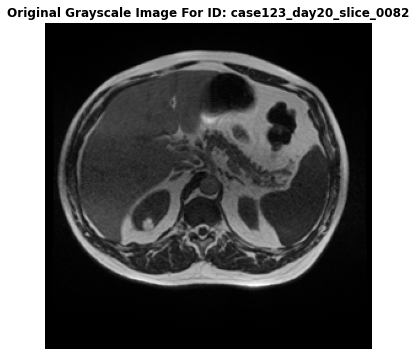



... 3 SEGMENTATION MASKS ...



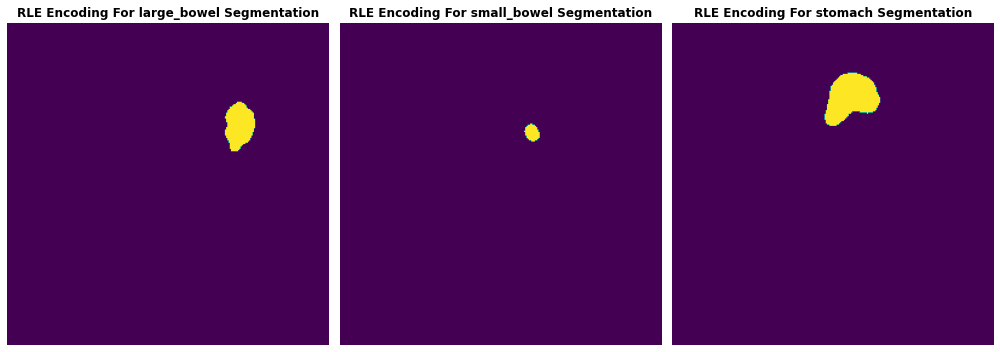



...IMAGE WITH AN RGB SEGMENTATION MASK OVERLAY ...



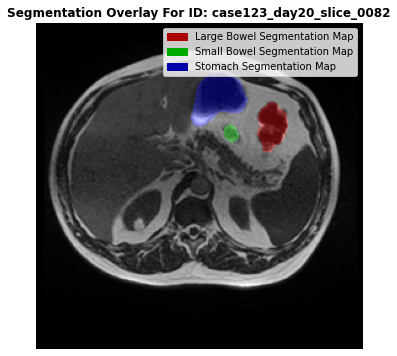

In [24]:
print("\n... SINGLE ID EXPLORATION ...\n\n")
DEMO_ID = "case123_day20_slice_0082"
examine_id(DEMO_ID, seg_masks=True)

# Cross-validation

In [25]:
# !conda list
#!pip uninstall -y scikit-learn
#!pip install scikit-learn
#!pip install --pre --extra-index https://pypi.anaconda.org/scipy-wheels-nightly/simple scikit-learn

#!pip install -U scikit-learn

In [26]:
#!pip install -U  matplotlib==3.1.1
#!pip install hypertools==0.8.0

In [27]:
#!pip install -U scikit-learn

In [28]:
#from sklearn.model_selection import StratifiedKFold, KFold, StratifiedGroupKFold

In [29]:
# Group by case id
skf = StratifiedGroupKFold(n_splits=n_splits, shuffle=True, random_state=42)
for fold, (_, val_idx) in enumerate(skf.split(X=train_df, y=train_df['count'], groups=train_df['case']), 1):
    train_df.loc[val_idx, 'fold'] = fold

train_df['fold'] = train_df['fold'].astype(np.uint8)

train_ids = train_df[train_df["fold"]!=fold_selected].index
valid_ids = train_df[train_df["fold"]==fold_selected].index

X_train = train_df[train_df.index.isin(train_ids)]
X_valid = train_df[train_df.index.isin(valid_ids)]

train_df.groupby('fold').size()

fold
1    8208
2    7036
3    7392
4    8704
5    6768
dtype: int64

In [30]:
# Fold sizes
train_df.groupby(['fold','count'])['id'].count()

fold  count
1     0        4803
      1         494
      2        2218
      3         693
2     0        4086
      1         352
      2        1972
      3         626
3     0        4164
      1         552
      2        2105
      3         571
4     0        4748
      1         606
      2        2614
      3         736
5     0        3860
      1         451
      2        1928
      3         529
Name: id, dtype: int64

# Model

In [31]:
! pip install segmentation-models

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.7/50.7 kB 1.7 MB/s eta 0:00:00


In [32]:
#! pip install git+https://github.com/qubvel/segmentation_models

In [33]:
import segmentation_models as sm
sm.set_framework('tf.keras')
sm.framework()

Segmentation Models: using `keras` framework.


'tf.keras'

In [34]:
#Data generators 
train_generator = DataGenerator(X_train, shuffle=True)
val_generator = DataGenerator(X_valid)

In [35]:
from segmentation_models import Unet
from segmentation_models.utils import set_trainable

input_layer = keras.Input(shape = (IMAGE_HEIGHT, IMAGE_WIDTH, 3))
output = Unet(backbone_name='inceptionresnetv2', encoder_weights='imagenet' ,classes=3, activation='sigmoid', decoder_block_type='transpose')(input_layer)
model = keras.Model(input_layer,output)
model.compile(optimizer='adam', loss=bce_dice_loss, metrics=[dice_coef,iou_coef])

2022-08-06 08:19:42.244306: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-08-06 08:19:42.380836: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-08-06 08:19:42.381679: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-08-06 08:19:42.383362: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compil

219070464/219055592 [==============================] - 56s 0us/step


# Training model

In [36]:
checkpoint = ModelCheckpoint(
    'UNET_model',
    monitor='val_loss',
    verbose=1,
    save_best_only=True,
    save_weights_only=False,
    mode='auto',
)

early_stopping = EarlyStopping(
    patience=5,
    min_delta=0.0001,
    restore_best_weights=True,
)

def scheduler(epoch, lr):
    if epoch < 13:
        return lr
    else:
        return lr * tf.math.exp(-0.1)

lr_scheduler = tf.keras.callbacks.LearningRateScheduler(scheduler)

In [ ]:
# history = model.fit(
#     train_generator,
#     validation_data=val_generator,
#     callbacks=[checkpoint, early_stopping, lr_scheduler],
#     use_multiprocessing=False,
#     workers=4,
#     epochs=EPOCHS
# )

In [37]:
# History
hist_df = pd.DataFrame(history.history)
hist_df.to_csv('history.csv')

# PLOT TRAINING
plt.figure(figsize=(15,5))
plt.subplot(1,3,1)
plt.plot(range(history.epoch[-1]+1),history.history['loss'],label='Train_Loss')
plt.plot(range(history.epoch[-1]+1),history.history['val_loss'],label='Val_loss')
plt.title('LOSS'); plt.xlabel('Epoch'); plt.ylabel('loss');plt.legend();

plt.subplot(1,3,2)
plt.plot(range(history.epoch[-1]+1),history.history['dice_coef'],label='Train_dice_coef')
plt.plot(range(history.epoch[-1]+1),history.history['val_dice_coef'],label='Val_dice_coef')
plt.title('DICE'); plt.xlabel('Epoch'); plt.ylabel('dice_coef');plt.legend(); 

plt.subplot(1,3,3)
plt.plot(range(history.epoch[-1]+1),history.history['iou_coef'],label='Train_iou_coef')
plt.plot(range(history.epoch[-1]+1),history.history['val_iou_coef'],label='Val_iou_coef')
plt.title('IOU'); plt.xlabel('Epoch'); plt.ylabel('iou_coef');plt.legend();
plt.show()

NameError: name 'history' is not defined

# Evaluation

In [39]:
custom_objects = custom_objects={
    'dice_coef': dice_coef,
    'iou_coef': iou_coef,
    'bce_dice_loss': bce_dice_loss
}
model = load_model('../input/gi-tract-segmentation-deeplearning-2/UNET_model', custom_objects=custom_objects)


**Preview predictions**

In [57]:
# pred_batches = DataGenerator(test_df, batch_size = 1, subset="train", shuffle=False)
# preds = model.predict_generator(pred_batches,verbose=1)

# Threshold = 0.5
# # Visualizing
# fig = plt.figure(figsize=(10, 25))
# gs = gridspec.GridSpec(nrows=8, ncols=3)
# colors = ['yellow','green','red']
# labels = ["Large Bowel", "Small Bowel", "Stomach"]
# patches = [ mpatches.Patch(color=colors[i], label=f"{labels[i]}") for i in range(len(labels))]

# cmap1 = mpl.colors.ListedColormap(colors[0])
# cmap2 = mpl.colors.ListedColormap(colors[1])
# cmap3= mpl.colors.ListedColormap(colors[2])

# for i in range(8):
#     images, mask = pred_batches[i]
#     sample_img=images[0,:,:,0]
#     mask1=mask[0,:,:,0]
#     mask2=mask[0,:,:,1]
#     mask3=mask[0,:,:,2]
    
#     pre=preds[i]
#     predict1=pre[:,:,0]
#     predict2=pre[:,:,1]
#     predict3=pre[:,:,2]
    
#     predict1= (predict1 > Threshold).astype(np.float32)
#     predict2= (predict2 > Threshold).astype(np.float32)
#     predict3= (predict3 > Threshold).astype(np.float32)
    
#     ax0 = fig.add_subplot(gs[i, 0])
#     im = ax0.imshow(sample_img, cmap='bone')
#     ax0.set_title("Image", fontsize=12, y=1.01)
#     #--------------------------
#     ax1 = fig.add_subplot(gs[i, 1])
#     ax1.set_title("Mask", fontsize=12,  y=1.01)
#     l0 = ax1.imshow(sample_img, cmap='bone')
#     l1 = ax1.imshow(np.ma.masked_where(mask1== False,  mask1),cmap=cmap1, alpha=1)
#     l2 = ax1.imshow(np.ma.masked_where(mask2== False,  mask2),cmap=cmap2, alpha=1)
#     l3 = ax1.imshow(np.ma.masked_where(mask3== False,  mask3),cmap=cmap3, alpha=1)
#     #--------------------------
#     ax2 = fig.add_subplot(gs[i, 2])
#     ax2.set_title("Predict", fontsize=12, y=1.01)
#     l0 = ax2.imshow(sample_img, cmap='bone')
#     l1 = ax2.imshow(np.ma.masked_where(predict1== False,  predict1),cmap=cmap1, alpha=1)
#     l2 = ax2.imshow(np.ma.masked_where(predict2== False,  predict2),cmap=cmap2, alpha=1)
#     l3 = ax2.imshow(np.ma.masked_where(predict3== False,  predict3),cmap=cmap3, alpha=1)
   

#     _ = [ax.set_axis_off() for ax in [ax0,ax1,ax2]]
#     colors = [im.cmap(im.norm(1)) for im in [l1,l2, l3]]
#     plt.legend(handles=patches, bbox_to_anchor=(1.1, 0.65), loc=2, borderaxespad=0.4,fontsize = 12,title='Mask Labels', title_fontsize=12, edgecolor="black",  facecolor='#c5c6c7')


# Test set predictions

In [48]:
pred_batches = DataGenerator(test_df, batch_size = BATCH_SIZE, subset="train", shuffle=False)
num_batches = int(len(test_df)/BATCH_SIZE)
submission1 = submission.copy()
for i in range(num_batches):
    # Predict
    preds = model.predict_generator(pred_batches,verbose=0)  
    
    # Rle encode
    for j in range(BATCH_SIZE):
        for k in range(3):
            pred_img = cv2.resize(preds[i*BATCH_SIZE+j,:,:,k], (test_df.loc[i*BATCH_SIZE+j,"width"], test_df.loc[i*BATCH_SIZE+j,"height"]), interpolation=cv2.INTER_NEAREST) # resize probabilities to original shape
            pred_img = (pred_img>0.5).astype(dtype='uint8')    # classify
            submission.loc[115188 + 3*(i*BATCH_SIZE+j)+k,'prediction'] = rle_encode(pred_img)
            submission1.iloc[3*(i*BATCH_SIZE+j)+k,2] = rle_encode(pred_img)

**Save predictions**

In [55]:
submission.to_csv('submission.csv',index=False)
submission.sample(20)

,id,class,prediction
115306,case30_day0_slice_0084,small_bowel,
115399,case30_day0_slice_0115,small_bowel,21222 1 21488 1 21751 6 22016 9 22282 11 22547...
115191,case30_day0_slice_0046,large_bowel,
115249,case30_day0_slice_0065,small_bowel,
115422,case30_day0_slice_0123,large_bowel,17991 12 18242 4 18254 18 18507 7 18519 21 187...
115227,case30_day0_slice_0058,large_bowel,
115302,case30_day0_slice_0083,large_bowel,
115403,case30_day0_slice_0116,stomach,17161 3 17165 11 17414 29 17677 34 17941 37 18...
115189,case30_day0_slice_0045,small_bowel,
115394,case30_day0_slice_0113,stomach,17421 6 17683 12 17947 17 18208 24 18470 29 18...


In [56]:
submission1.to_csv('submission1.csv',index=False)
submission1.sample(20)

,id,class,prediction
115482,case30_day0_slice_0143,large_bowel,
115472,case30_day0_slice_0139,stomach,
115311,case30_day0_slice_0086,large_bowel,
115446,case30_day0_slice_0131,large_bowel,
115485,case30_day0_slice_0144,large_bowel,
115321,case30_day0_slice_0089,small_bowel,
115354,case30_day0_slice_0100,small_bowel,
115360,case30_day0_slice_0102,small_bowel,
115278,case30_day0_slice_0075,large_bowel,
115204,case30_day0_slice_0050,small_bowel,


In [49]:
pred_batches = DataGenerator(test_df, batch_size =1, subset = 'train', shuffle = True)

preds = model.predict(pred_batches, verbose = 1)


100/100 [==============================] - 4s 42ms/step


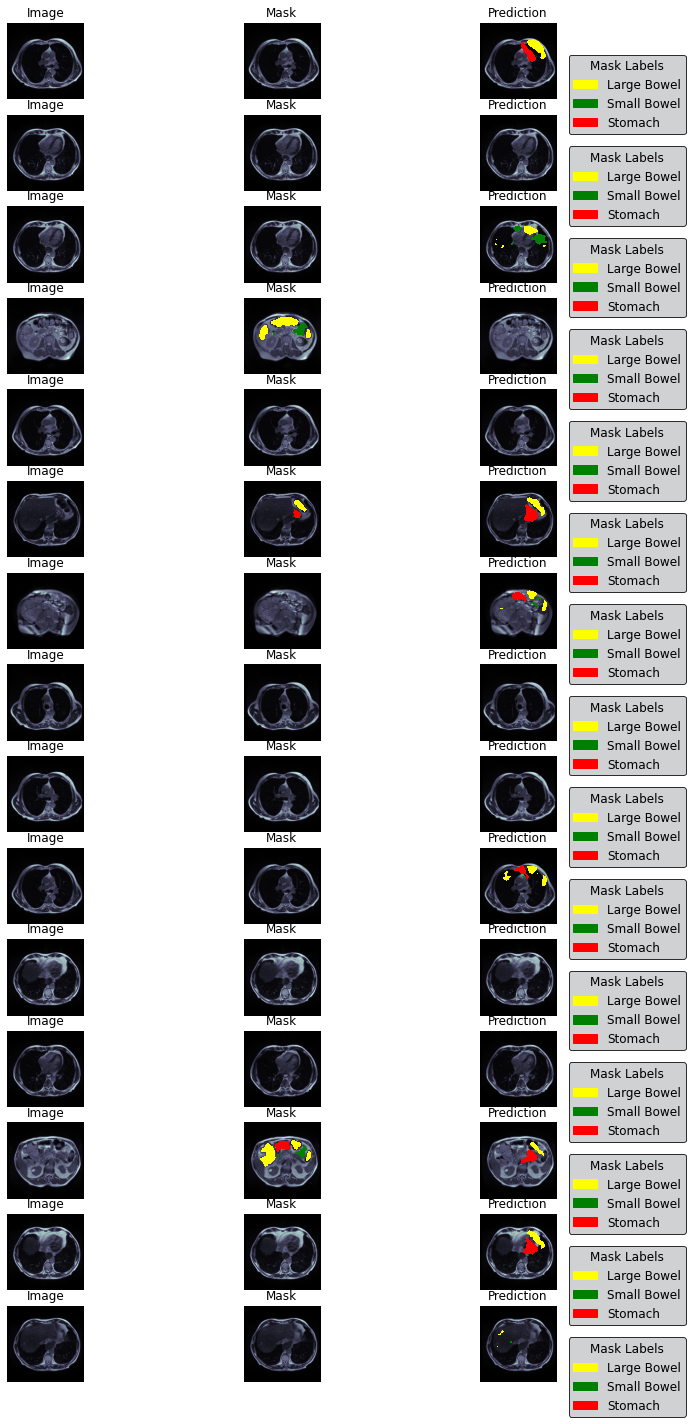

In [54]:
Threshold = 0.5

fig = plt.figure(figsize =(12, 25))
gs = gridspec.GridSpec(nrows = 15, ncols = 3)
colors = ['yellow','green','red']
labels = ["Large Bowel", "Small Bowel", "Stomach"]

patches = [mpatches.Patch(color=colors[i], label=f"{labels[i]}") for i in range(len(labels))]

cmap1 = mpl.colors.ListedColormap(colors[0])
cmap2 = mpl.colors.ListedColormap(colors[1])
cmap3 = mpl.colors.ListedColormap(colors[2])

for i in range(15):
    images, mask = pred_batches[i]
    sample_img = images[0, :, :, 0]
    
    mask1 = mask[0, :, :, 0]
    mask2 = mask[0, :, :, 1]
    mask3 = mask[0, :, :, 2]
    
    prediction_i = preds[i]
    predict1 = prediction_i[:, :, 0]
    predict2 = prediction_i[:, :, 1]
    predict3 = prediction_i[:, :, 2]
    
    predict1 = (predict1 > Threshold).astype(np.float32)
    predict2 = (predict2 > Threshold).astype(np.float32)
    predict3 = (predict3 > Threshold).astype(np.float32)
    
    ax0 = fig.add_subplot(gs[i, 0])
    im = ax0.imshow(sample_img, cmap='bone')
    ax0.set_title("Image", fontsize=12, y=1.01)
    
    ax1 = fig.add_subplot(gs[i, 1])
    ax1.set_title("Mask", fontsize=12, y=1.01)
    l0 = ax1.imshow(sample_img, cmap="bone")
    l1 = ax1.imshow(np.ma.masked_where(mask1 == False, mask1), cmap=cmap1, alpha=1)
    l2 = ax1.imshow(np.ma.masked_where(mask2 == False, mask2), cmap=cmap2, alpha=1)
    l3 = ax1.imshow(np.ma.masked_where(mask3 == False, mask3), cmap=cmap3, alpha=1)
    
    ax2 = fig.add_subplot(gs[i, 2])
    ax2.set_title("Prediction", fontsize=12, y=1.01)
    l0 = ax2.imshow(sample_img, cmap="bone")
    l1 = ax2.imshow(np.ma.masked_where(predict1 == False, predict1), cmap=cmap1, alpha=1)
    l2 = ax2.imshow(np.ma.masked_where(predict2 == False, predict2), cmap=cmap2, alpha=1)
    l3 = ax2.imshow(np.ma.masked_where(predict3 == False, predict3), cmap=cmap3, alpha=1)
    
    _ = [ax.set_axis_off() for ax in [ax0, ax1, ax2]]
    colors = [im.cmap(im.norm(1)) for im in [l1, l2, l3] ]
    plt.legend(handles=patches, bbox_to_anchor=(1.1, 0.65), loc=2, borderaxespad=0.4, fontsize=12, title="Mask Labels", title_fontsize=12, edgecolor='black', facecolor='#c5c6c7' )

In [ ]:
hist_df

In [ ]:
ouut = (
    hist_df.pipe(lambda d: d.div(d['c'], axis='index'))
    .applymap('{:.0%}'.format)
)